## The TikTok Effect on an Artist’s Streaming Performance on Spotify


### Background 
Reaching its peak usage during the pandemic, TikTok has become Gen Z’s go-to platform for discovering new music. Songs are turned into sounds that can be used in videos by all users, and if they gain enough traction they can catapult an artist onto the top of charts in no time. According to a [study by music-analytics company MRC data in 2021](https://newsroom.tiktok.com/en-us/new-studies-quantify-tiktoks-growing-impact-on-culture-and-music), 67% of TikToker users are more likely to seek out a song they heard on TikTok on a music streaming platform. After hearing the 15 second clip on TikTok, users want to listen to the rest of the song on their preferred music streaming platform, which would lead to a boost in their monthly listeners. 
Spotify remains the most widely-used music streaming service worldwide, with a 30.5% share of the market. Therefore, this project aims to investigate the impact that the virality of a TikTok sound has on an artist's Spotify streaming performance specifically. 

[Spotify remains the most widely-used music streaming service worldwide, with a 30.5% share of the market.](https://www.midiaresearch.com/blog/music-subscriber-market-shares-2022) Therefore, this project aims to investigate the impact that the virality of a TikTok sound has on an artist's Spotify streaming performance specifically.

In [62]:
# import packages 
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from itertools import cycle
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from scipy.stats import ttest_ind
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
import statsmodels.stats.api as sms
import statsmodels.api as sm



### Creating the Datasets
This project uses data from [Chartmetric](https://chartmetric.com/), a music analytics software that tracks an artists’ performance across multiple channels including Spotify and TikTok. 
To deduce the impact of TikTok virality on an artist’s Spotify performance, we decided to look at the weekly “Top Tracks in the United States” chart for TikTok (removing original sounds that were voiceovers by users) and the weekly “Top Artists” chart for Spotify. The time period investigated in this project is 2022, as this was the first year that Chartmetric has data for both TikTok and Spotify. As the data for 2022 is tracked weekly, we had to download 53 datasets each for both platforms and then combine them into two datasets respectively. In order to do this clearly, we used the date that the data for the week was taken from as an index.

In [2]:
folder_path1 = 'tiktok'
all_files1 = os.listdir(folder_path1)
all_dataframes1 = []

In [3]:
# function to parse file titles as dates
def parse_date_from_filename(filename):
    try:
        return datetime.strptime(filename.split('.')[0], '%m:%d:%Y')
    except ValueError:
        return None

valid_files1 = [file for file in all_files1 if parse_date_from_filename(file) is not None]

sorted_files1 = sorted(valid_files1, key=parse_date_from_filename)

all_dataframes1 = []

# sort and read files
for file in sorted_files1:
    if file.endswith('.csv'):
        file_path1 = os.path.join(folder_path1, file)
        date = file.split('.')[0]
        
        df = pd.read_csv(file_path1)
        df['date'] = date
        all_dataframes1.append(df)

# merge files into one dataset
tiktok = pd.concat(all_dataframes1, ignore_index=True)

In [4]:
folder_path2 = 'spotify'
all_files2 = os.listdir(folder_path2)
all_dataframes2 = []

In [5]:
valid_files2 = [file for file in all_files2 if parse_date_from_filename(file) is not None]

sorted_files2 = sorted(valid_files2, key=parse_date_from_filename)

all_dataframes2 = []

# sort and read files
for file in sorted_files2:
    if file.endswith('.csv'):
        file_path2 = os.path.join(folder_path2, file)
        date = file.split('.')[0]
        
        df = pd.read_csv(file_path2)
        df['date'] = date
        all_dataframes2.append(df)

# merge files into one dataset
spotify = pd.concat(all_dataframes2, ignore_index=True)

In [6]:
#set index
tiktok['index'] = tiktok.groupby('date').cumcount()
tiktok = tiktok.set_index(['date', 'index'])

In [7]:
spotify['index'] = spotify.groupby('date').cumcount()
spotify = spotify.set_index(['date', 'index'])

## EDA

### Cleaning the Tiktok Dataset

In [8]:
#drop irrelevant columns
tiktok=tiktok.drop(["Internal Link","External Link","ISRC","Song ID","Label"], axis=1)

In [9]:
#Drop Nas and irrelevant columns
tiktok = tiktok.dropna(subset=['Artists'])
tiktok = tiktok.drop('Change', axis=1)

In [10]:
#function to turn column to integer
def convert_string_to_int(s):
    if s[-1] == 'K':
        return int(float(s[:-1]) * 1000)
    elif s[-1] == 'M':
        return int(float(s[:-1]) * 1000000)
    else:
        return int(s)

tiktok['Video Count'] = tiktok['Video Count'].apply(convert_string_to_int)
tiktok['All-Time Video Count'] = tiktok['All-Time Video Count'].apply(convert_string_to_int)

In [11]:
tiktok["Peak Date"] = pd.to_datetime(tiktok["Peak Date"])
tiktok["Release Date"] = pd.to_datetime(tiktok["Release Date"])

In [12]:
tiktok = tiktok.dropna()


After cleaning the data, the columns for the weekly “Top Tracks in the United States” in the TikTok dataset are:

- Rank - The weekly ranking for the Top 200 tracks that were used on TikTok for that week. 
- Track - Name of Track 
- Artist - The artist that created the song. 
- Release Date - The date the track/sound was released or first used on TikTok 
- All Time Rank - The rank of the track based on the number of videos it has been used in since its release on TikTok.
- Video Count - The number of videos that the track was used in for the week, which determines the Rank. 
- All Time Video Count - The number of videos that the track was used in since its release on TikTok.
- Peak Position - The highest rank the track has held  since its release on TikTok.
- Peak Date - The date the track reached its Peak Position. 
- Weeks on Chart - The cumulative total number of weeks the track has been in the Top Tracks Charts up until the specified date 
- 7 Day Velocity - The average rank growth the track has had everyday in the past week. Chartmetric calculates 7 Day Velocity with taking the change in rank today vs the week before and divides it by 7.


### Exploring the Tiktok Dataset

In [13]:
#descriptive statistics
print(tiktok.info())   
print(tiktok.describe())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6181 entries, ('01:02:2022', 0) to ('01:01:2023', 197)
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Rank                  6181 non-null   int64         
 1   Track                 6181 non-null   object        
 2   Artists               6181 non-null   object        
 3   Release Date          6181 non-null   datetime64[ns]
 4   All Time Rank         6181 non-null   int64         
 5   Video Count           6181 non-null   int64         
 6   All-Time Video Count  6181 non-null   int64         
 7   Peak Position         6181 non-null   int64         
 8   Peak Date             6181 non-null   datetime64[ns]
 9   Weeks on Chart        6181 non-null   int64         
 10  7-Day Velocity        6181 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(6), object(2)
memory usage: 561.5+ KB
None
              Rank  

In [14]:
def get_min_max_values(dataframe):
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Loop through each column to compute min, max
    min_max_dict = {}
    for col in numeric_cols:
        min_val = dataframe[col].min()
        max_val = dataframe[col].max()
        min_max_dict[col] = [min_val, max_val]

    # new df
    min_max_df = pd.DataFrame.from_dict(min_max_dict, orient='index', columns=['Min', 'Max'])

    return min_max_df

get_min_max_values(tiktok)

,Min,Max
Rank,1.00,200.00
All Time Rank,1.00,189.00
Video Count,23000.00,1900000.00
All-Time Video Count,62000.00,32000000.00
Peak Position,1.00,195.00
Weeks on Chart,2.00,104.00
7-Day Velocity,-25.57,26.29


<AxesSubplot:>

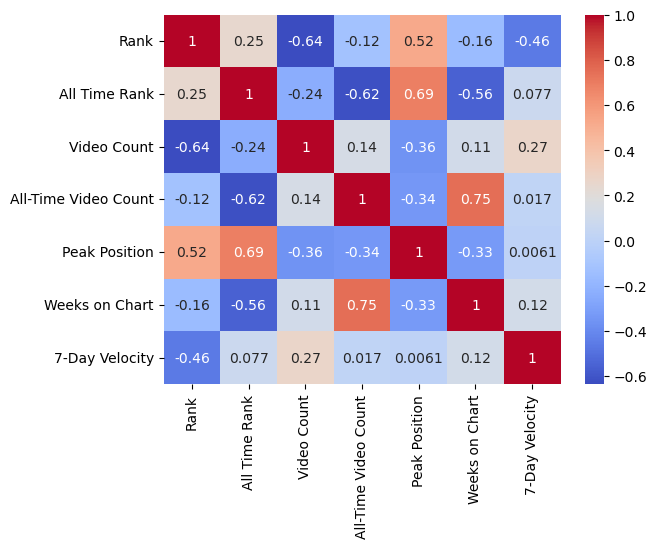

In [15]:
corr_matrix=tiktok.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

To understand how other variables in the TikTok dataset correlate with the Rank of the tracks in the TikTok dataset, we use the correlation matrix  between pairs of variables in the TikTok dataset. The values in the matrix range from -1 to 1, where -1 represents a perfectly negative correlation, 0 represents no correlation, and 1 represents a perfectly positive correlation. As mentioned, our main interest variable in the TikTok dataset is the Rank. We observe the following:

- The correlation coefficient between “Rank” and “Video Count” is -0.65, which indicates a strong negative correlation. This means that as the Video Count increases, the number of the Rank tends to decrease.
- The correlation coefficient between “Rank” and “All Time Video Count” is -0.14, which indicates a weak negative correlation. This means that as the All Time Video Count increases, the number of the Rank tends to decrease. This is a weaker correlation than with “Video Count” as “All Time Video Count” is the number of videos since the Track released on Tiktok.
- The correlation coefficient between “Rank” and “Weeks on Chart” is -0.18, which indicates a weak negative correlation. This means that tracks that spend the most time on the charts could sometimes have a lower number of Rank.
- The correlation coefficient between “Rank” and “7 Day Velocity” is -0.46, which indicates a moderate negative correlation. This means that tracks with a higher Rank tend to have a lower 7 Day Velocity. 

It is very important to note that Rank is an inverse variable as the lower the number of the rank, the higher the track it is on the charts. So, the negative correlation intuitively makes sense.

- The correlation coefficient between “Rank” and “All Time Rank” is 0.27, which indicates a weak positive correlation. This means that the higher the track is ranked in on the charts, it could have a higher All Time Rank as well, depending on its popularity overall.
- The correlation coefficient between “Rank” and “Peak Position” is 0.58, which indicates a moderate positive correlation. This means that the higher the Rank of the track on the chart, the Peak Position would also tend to be high.




In [16]:
#function to create matrix
def scatter_matrix_with_regression(dataframe, x_column, y_columns):
    g = sns.PairGrid(dataframe, y_vars=y_columns, x_vars=[x_column], height=3, aspect=1.5)
    g.map(sns.regplot, line_kws={'color': 'red'})
    
    plt.suptitle('Scatterplot Matrix with Linear Regression: {} vs. {}'.format(x_column, ', '.join(y_columns)), fontsize=16)

    plt.show()

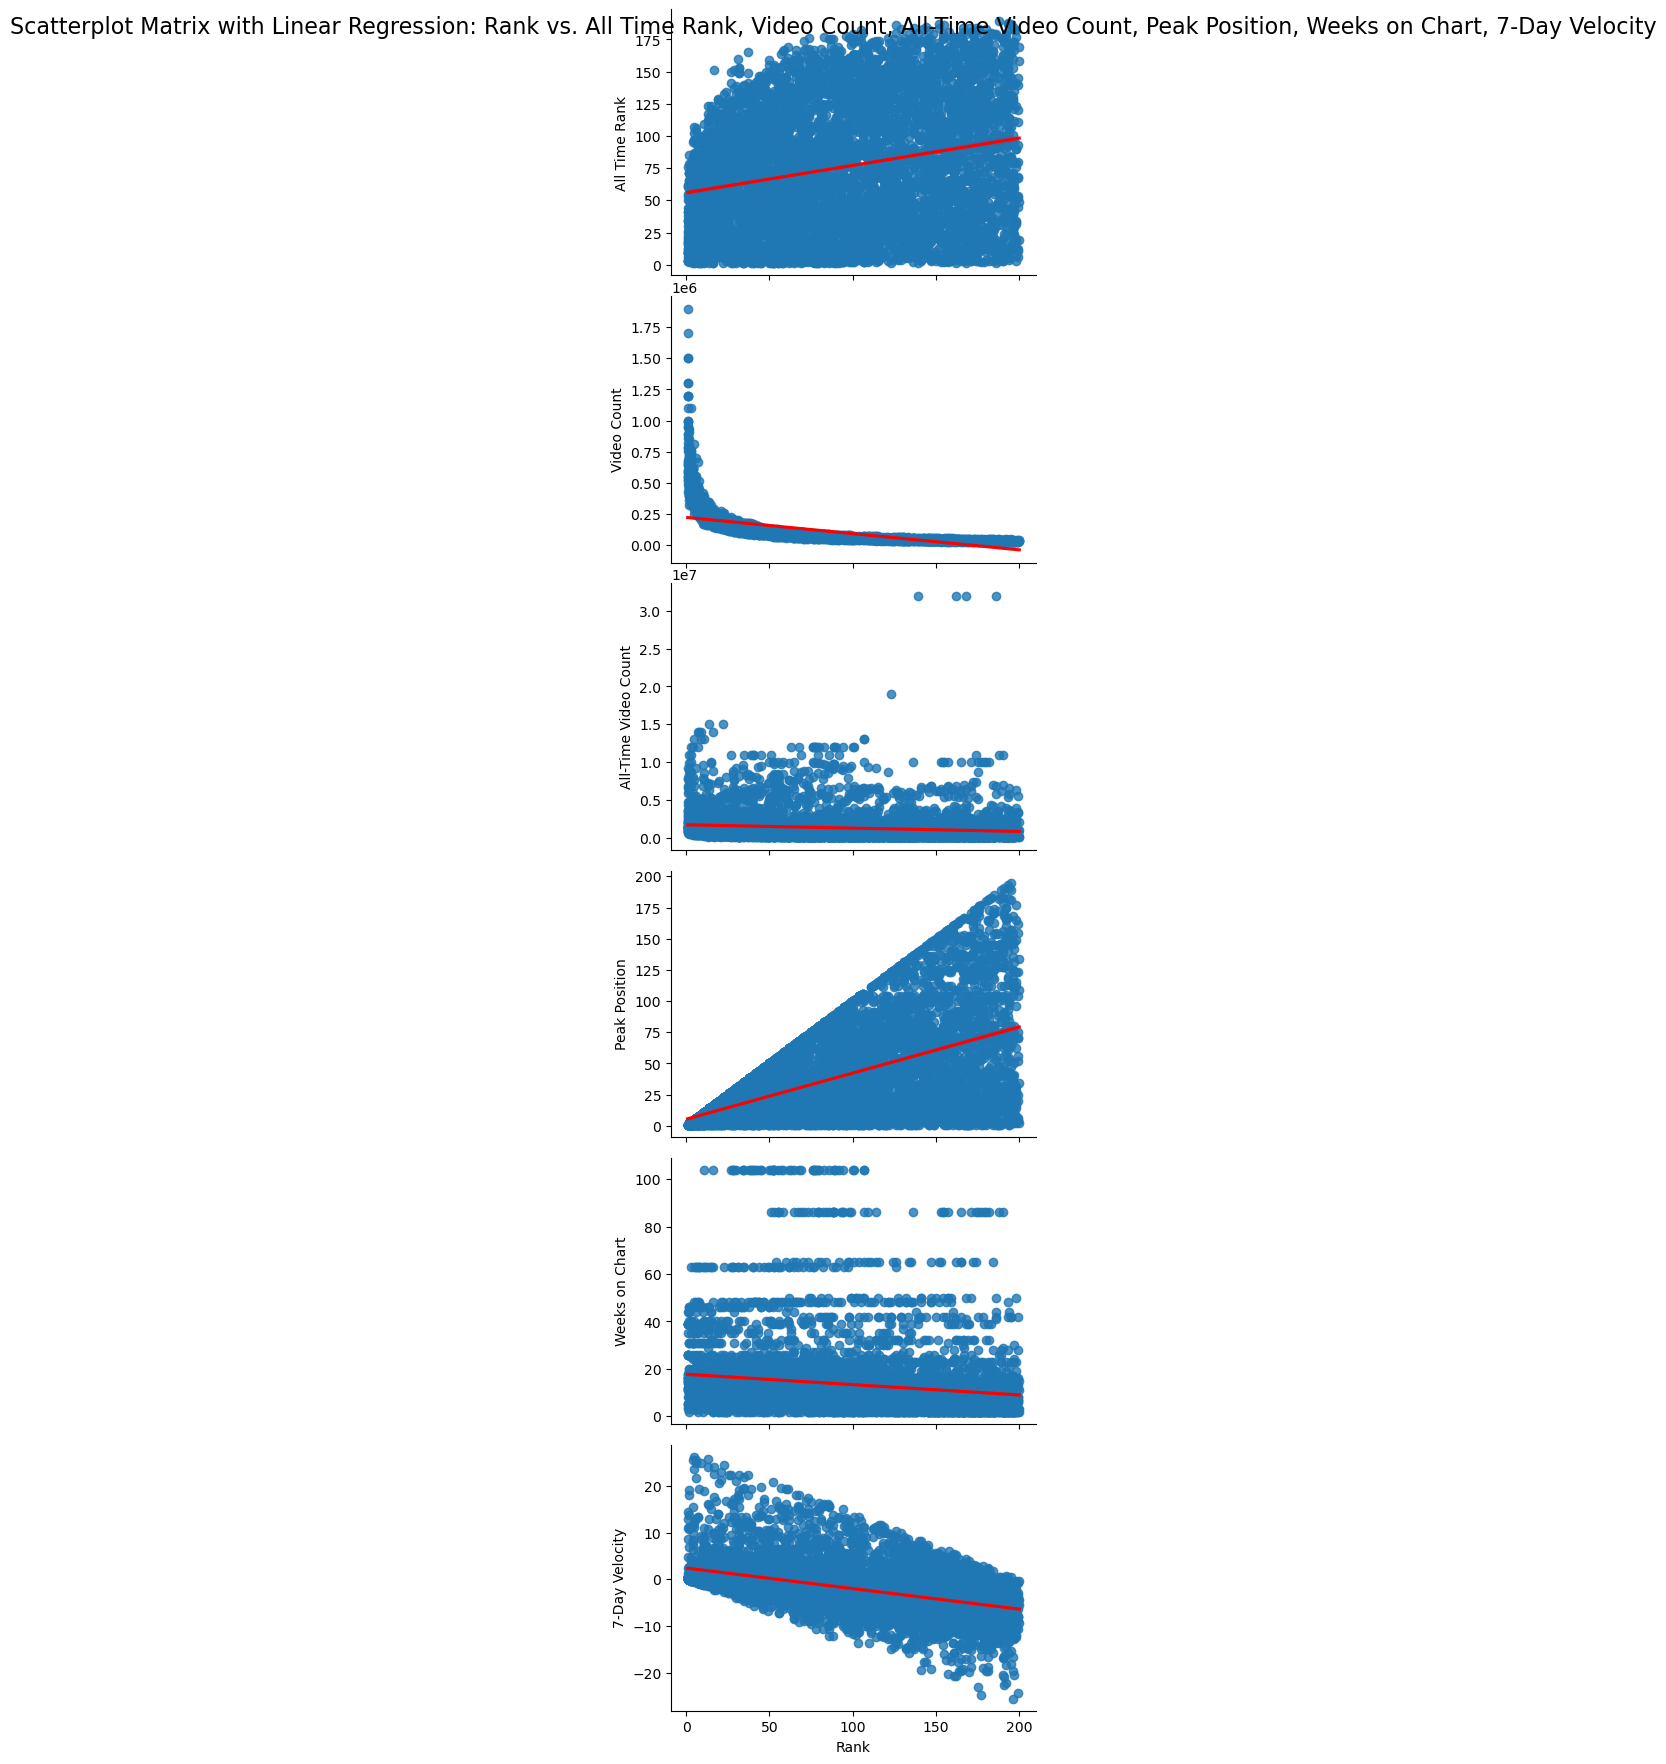

In [17]:
comparison_cols_tiktok = tiktok.select_dtypes(include=['int64', 'float64']).columns.tolist()
comparison_cols_tiktok.remove('Rank')
#apply function
scatter_matrix_with_regression(tiktok, 'Rank', comparison_cols_tiktok)

To further explore the correlation between Rank and the other variables, we use a scatter plot with a regression line. These regression lines show us the same results as the correlation matrix.


### Cleaning the Spotify Dataset

In [18]:
#drop Na values and transform column into int
spotify = spotify.drop(["Country","Internal Link"],axis = 1)
spotify['Monthly Listeners'] = spotify['Monthly Listeners'].apply(convert_string_to_int)

In [19]:
#transform date column
spotify["Peak Date"] = pd.to_datetime(spotify["Peak Date"])

After cleaning the data, the columns for the weekly “Top Artists” in the Spotify dataset are: 
- Rank - The weekly ranking for the Top 1000 Artists on Spotify.
- Change - The change in the artist’s rank; it is positive for an increase, negative for a decrease, 0 for no change, or “New” if they appeared on the charts for the first time. 
- Artist - The name of the artist. 
- Monthly Listeners - The total number of listeners for the artist in that month.
- Weekly Listeners Change - The change in the number of listeners for the artist in that week.
- Peak Position - The highest rank the artists has held since they first released music on Spotify.
- Peak Date - The date the artist reached their Peak Position. 
- Weeks on Chart - The cumulative total number of weeks the artist has been in the Top Artists Charts up until the specified date. 
- Current Weekly Streak - The consecutive number of weeks the artist has been in the Top Artists Charts until the specified date.


### Exploring the Spotify Dataset

In [20]:
#Descriptive Statistics
print(spotify.info())   
print(spotify.describe())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53000 entries, ('01:06:2022', 0) to ('12:29:2022', 999)
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Rank                     53000 non-null  int64         
 1   Change                   53000 non-null  int64         
 2   Artist                   53000 non-null  object        
 3   Monthly Listeners        53000 non-null  int64         
 4   Weekly Listeners Change  53000 non-null  int64         
 5   Peak Position            53000 non-null  int64         
 6   Peak Date                53000 non-null  datetime64[ns]
 7   Weeks on Chart           53000 non-null  int64         
 8   Current Weekly Streak    53000 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 3.8+ MB
None
               Rank        Change  Monthly Listeners  Weekly Listeners Change  \
count  53000.000000  53000.000000   

In [21]:
print(spotify.isnull().sum())

Rank                       0
Change                     0
Artist                     0
Monthly Listeners          0
Weekly Listeners Change    0
Peak Position              0
Peak Date                  0
Weeks on Chart             0
Current Weekly Streak      0
dtype: int64


There are no null values in this dataset. 

In [22]:
#min max
get_min_max_values(spotify)

,Min,Max
Rank,1,1000
Change,-936,945
Monthly Listeners,0,110000000
Weekly Listeners Change,66325,40649404
Peak Position,1,1000
Weeks on Chart,1,96
Current Weekly Streak,1,33


<AxesSubplot:>

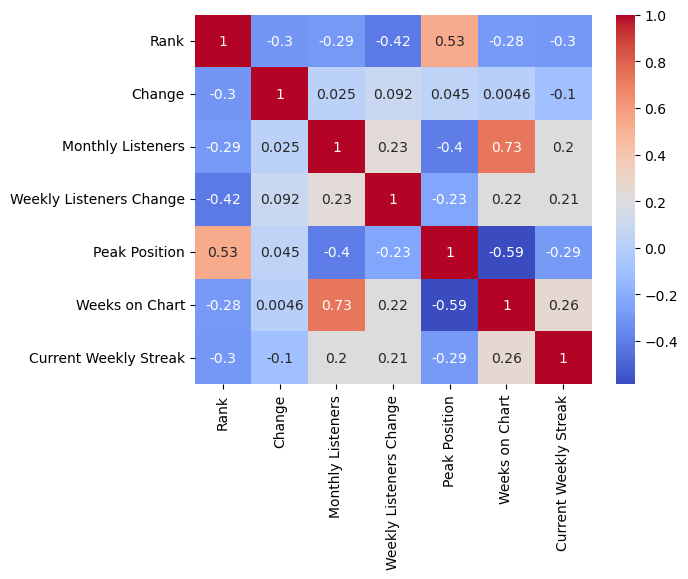

In [23]:
#correlation matrix
corr_matrix=spotify.corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

To understand how other variables in the Spotify dataset correlate with the Weekly Listeners Change of the artists in the Spotify dataset, we use the correlation matrix between pairs of variables in the Spotify dataset. Our main interest variable in the Spotify dataset is the Weekly Listeners Change. We observe the following: 

- The correlation coefficient between “Weekly Listeners Change” and “Rank” is -0.42, which indicates a moderate negative correlation. This means the artists that have a higher number of rank tend to have a smaller increase in weekly listeners.
- The correlation coefficient between “Weekly Listeners Change” and “Peak Position” is -0.23, which indicates a weak negative correlation. This means that artists with a higher Weekly Listeners Change would tend to have a Peak Position that would be lower in the number (a higher position on the charts)

It is very important to note that Rank is an inverse variable as the lower the number of the rank, the higher the track it is on the charts. So, the negative correlation intuitively makes sense.

- The correlation coefficient between “Weekly Listeners Change” and “Change” is 0.092, which indicates weak positive correlation. This means that artists that have a small change in rank could have a smaller increase in weekly listeners.
- The correlation coefficient between “Weekly Listeners Chnage” and “Monthly Listeners” is 0.23, which indicates a weak positive correlation.This means that artists with a larger increase in weekly listeners tend to have more monthly listeners.
- The correlation coefficient between “Weekly Listeners Change” and “Weeks on Chart” is 0.22, which indicates a weak positive correlation. This means that artists with a larger increase in the number of weekly listeners tend to spend more time on the chart.
- The correlation coefficient between “Weekly Listeners Change” and “Current Weekly Streak” is 0.21, which indicates a weak negative correlation. This means that artists with a larger increase in the number of weekly listeners tend to have longer weekly streaks on the charts.



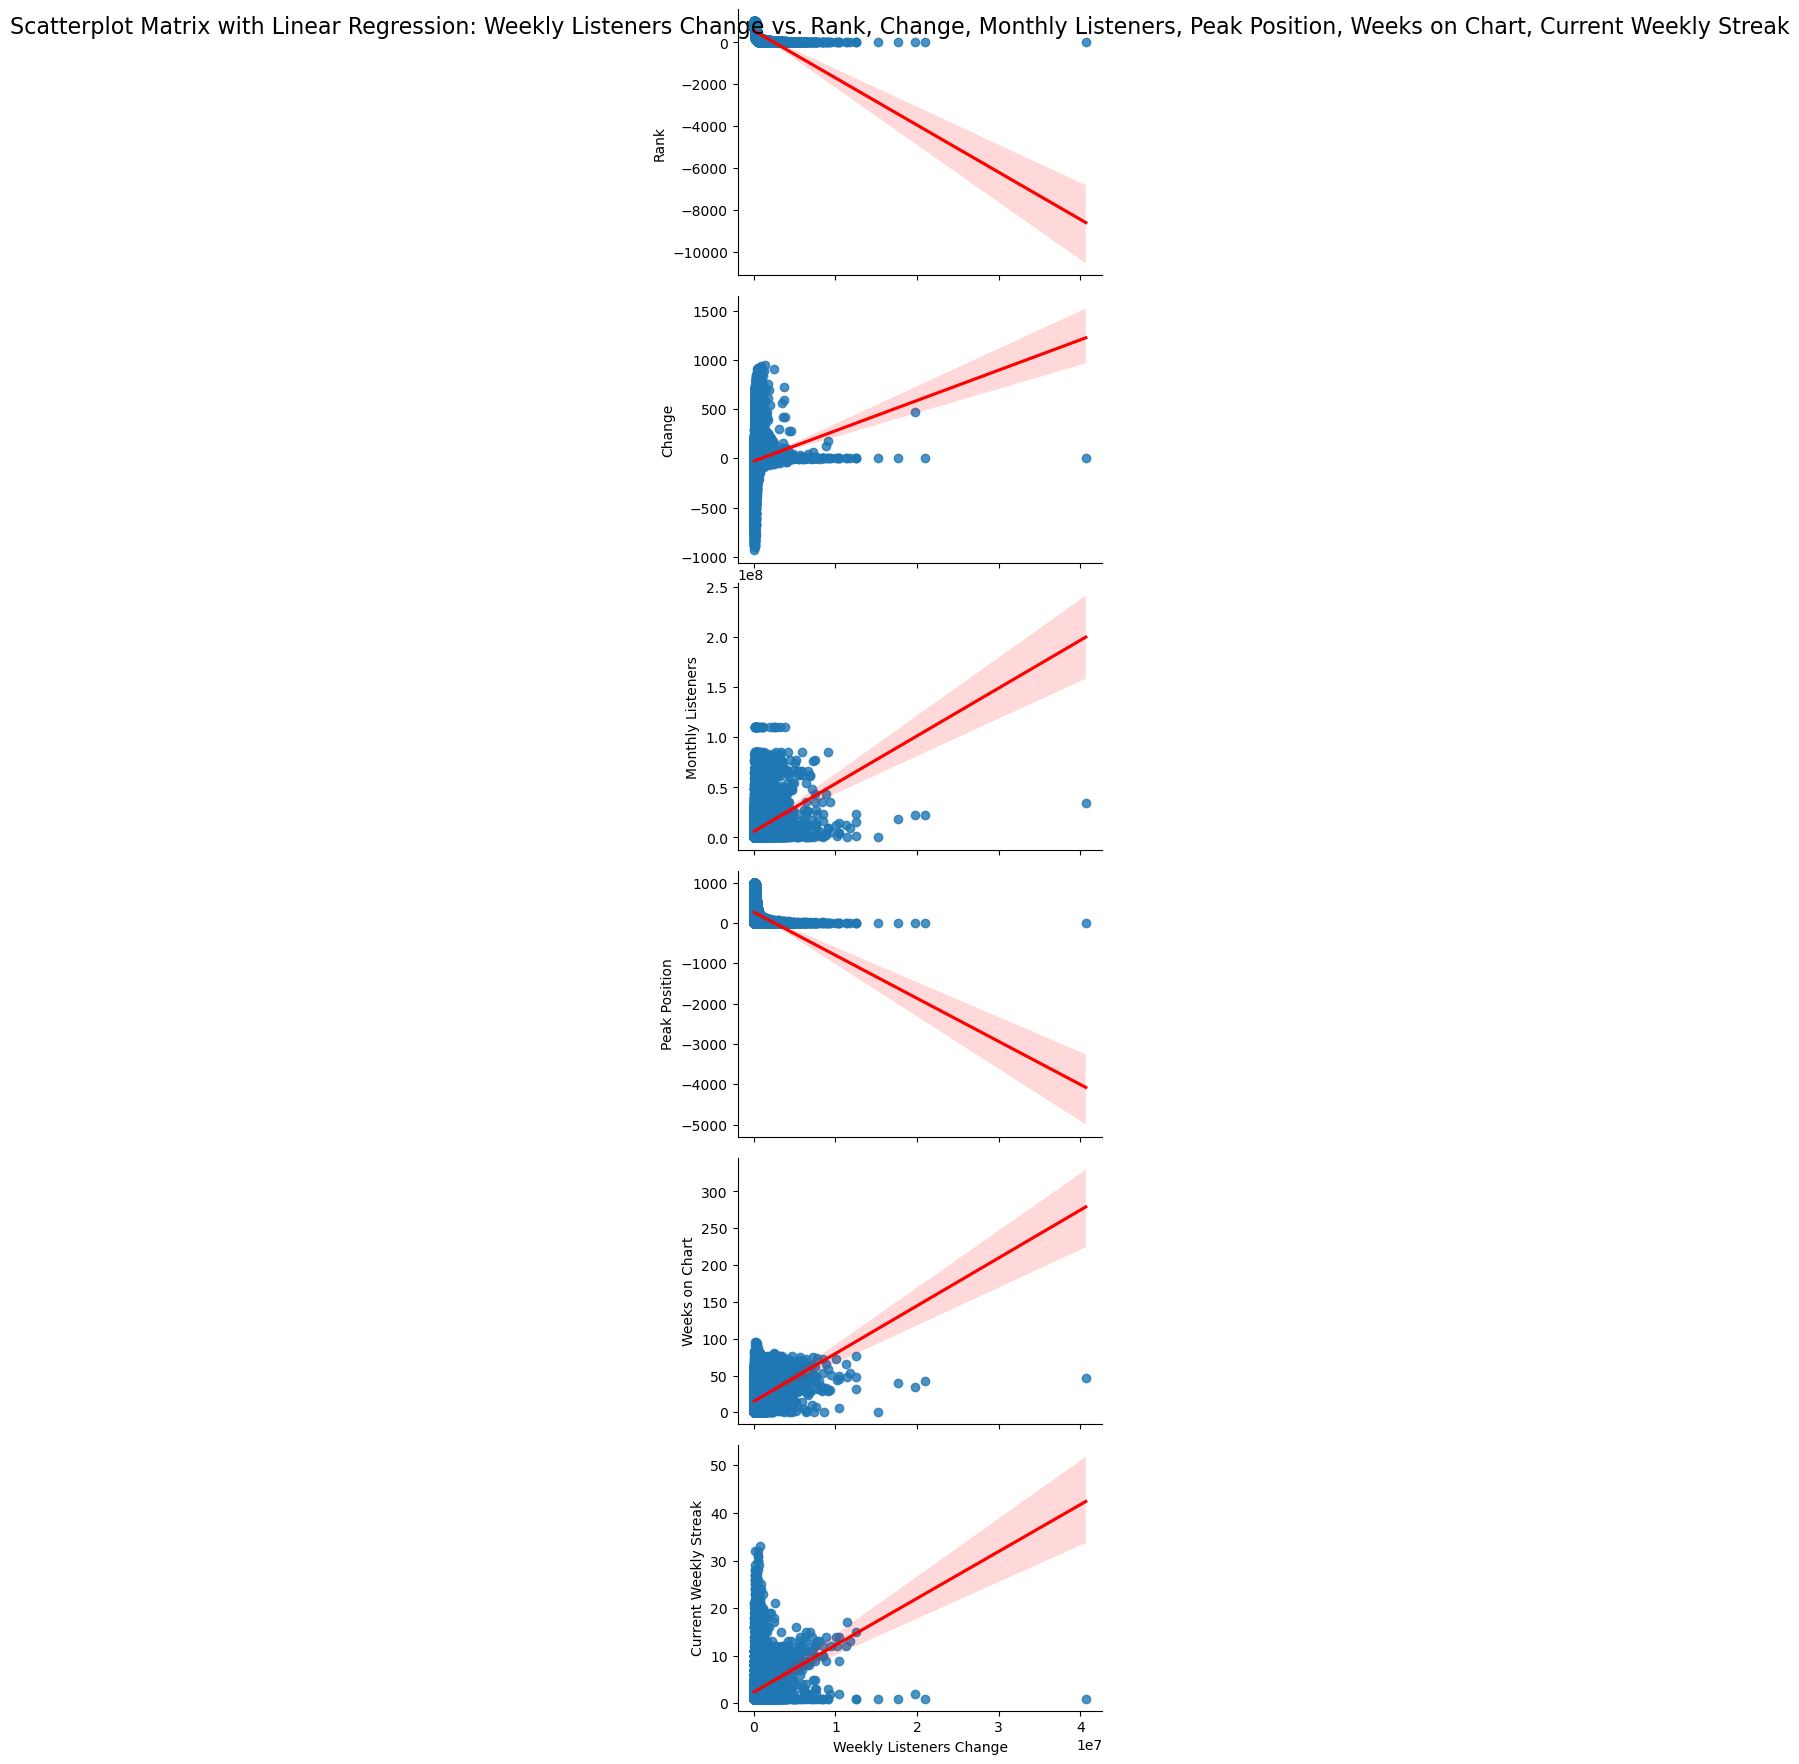

In [24]:
comparison_cols_spotify = spotify.select_dtypes(include=['int64', 'float64']).drop(['Weekly Listeners Change'], axis=1).columns.tolist()
#apply function scatter matrix
scatter_matrix_with_regression(spotify, 'Weekly Listeners Change', comparison_cols_spotify)

To further explore the correlation between Weekly Listeners Change and the other variables, we use a scatter plot with a regression line. These regression lines show us the same results as the correlation matrix.


### Exploring Artists on Tiktok

In [25]:
# Split Artists
artist_dates_df = tiktok.assign(Artists=tiktok.Artists.str.split(', ')).explode('Artists').reset_index()

# Group by artist and count unique dates on chart
artist_counts = artist_dates_df.groupby('Artists')['date'].nunique()

# max number of dates for artist on chart
max_artist_count = artist_counts.max()

# artisti with max count
max_artist_names = artist_counts[artist_counts == max_artist_count].index.tolist()

if len(max_artist_names) == 1:
    print('{} has been on the rank for {} dates, which is the maximum for any artist.'.format(max_artist_names[0], max_artist_count))
else:
    print('The following artists have been on the rank for {} weeks, which is the maximum for any artist: {}'.format(max_artist_count, ', '.join(max_artist_names)))


The following artists have been on the rank for 53 weeks, which is the maximum for any artist: Kevin, Kevin MacLeod


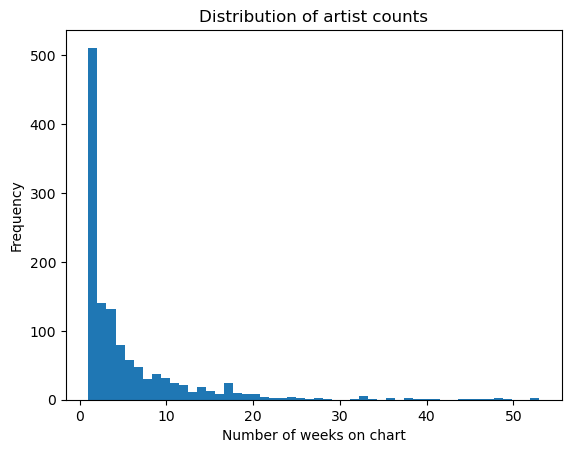

In [26]:
#histogram of the artist counts
artist_dates_df = tiktok.assign(Artists=tiktok.Artists.str.split(', ')).explode('Artists').reset_index()
artist_counts = artist_dates_df.groupby('Artists')['date'].nunique()
plt.hist(artist_counts, bins=50)
plt.xlabel('Number of weeks on chart')
plt.ylabel('Frequency')
plt.title('Distribution of artist counts')
plt.show()

The above histogram shows that most artists remain on the tiktok charts for about 1-2 weeks. The highest frequence (mode) is one week. However there many outliers with a very higher number of weeks, making the distribution extremely skewed

### TikTok Artist Rank Presence Prediction using Random Forest Classifier

In [27]:
#split and explode artists
pred_tiktok = tiktok
pred_tiktok['Artists'] = pred_tiktok['Artists'].str.split(',')
pred_tiktok = pred_tiktok.explode('Artists')

# create in_next_week
pred_tiktok['in_next_week'] = pred_tiktok.groupby('Artists')['Artists'].shift(-1).notna().astype(int)

pred_tiktok

Rank                                Track  \
date       index                                              
01:02:2022 0         1                  Own Brand Freestyle   
           0         1                  Own Brand Freestyle   
           0         1                  Own Brand Freestyle   
           1         2                        Happiest Year   
           2         3  Could've Been (feat. Bryson Tiller)   
...                ...                                  ...   
01:01:2023 190     191                            Hey There   
           191     192                               Palace   
           192     193                          We Gone Eat   
           194     195                         Hungry Eatin   
           197     198                                   TV   

                               Artists Release Date  All Time Rank  \
date       index                                                     
01:02:2022 0               FelixThe1st   2021-11-18             12   
           0                 Dréya Mac   2021-11-18             12   
           0               Finch Fetti   2021-11-18             12   
           1              Jaymes Young   2019-08-22             14   
           2                    H.E.R.   2019-08-27             60   
...                                ...          ...            ...   
01:01:2023 190                  Future   2019-08-17             81   
           191                ADTurnUp   2022-09-06            124   
           192    T-Speed & 5upamanHOE   2021-01-06             83   
           194              Tesla Boyz   2022-04-20             84   
           197           Billie Eilish   2022-07-20             53   

                  Video Count  All-Time Video Count  Peak Position  Peak Date  \
date       index                                                                
01:02:2022 0           647000               3500000              1 2021-12-11   
           0           647000               3500000              1 2021-12-11   
           0           647000               3500000              1 2021-12-11   
           1           396000               2700000              2 2022-01-01   
           2           393000                885000              3 2022-01-01   
...                       ...                   ...            ...        ...   
01:01:2023 190          43000                616000            143 2022-12-17   
           191          43000                277000            160 2022-12-24   
           192          42000                608000             63 2022-11-26   
           194          42000                608000             64 2022-11-26   
           197          42000               1200000             25 2022-11-12   

                  Weeks on Chart  7-Day Velocity  in_next_week  
date       index                                                
01:02:2022 0                  26            0.00             1  
           0                  26            0.00             1  
           0                  26            0.00             1  
           1                  12           10.86             1  
           2                  11            0.43             1  
...                          ...             ...           ...  
01:01:2023 190                 3           -5.00             0  
           191                 3           -4.57             0  
           192                 8           -5.14             0  
           194                 8           -5.29             0  
           197                16           -2.71             0  

[8827 rows x 12 columns]

In [28]:
#X and Y split
X = pred_tiktok.drop(columns=['in_next_week', 'Artists', 'Track', 'Release Date', 'Peak Date'])
y = pred_tiktok['in_next_week']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
#running the model
numeric_columns = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [30]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8965647414118535


**Accuracy**
The overall accuracy of the model is 0.8966. An accuracy rate of 89.66% means that this predictive model correctly predicts whether an artist would be in the Top Artist charts for the next week for 88.66% of cases.

In [31]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 252  167]
 [ 107 2123]]


**Confusion Matrix Results**
The Confusion Matrix gives us a summary of True Positives, True Negatives, False Positives, and False Negatives.
- True Positives: 252 artists were correctly predicted to be in the list next week. 
- True Negatives: 2123 artists were correctly predicted not to be in the list next week. 
- False Positive: 167 sartists were incorrectly predicted to be in the list next week; this is a Type I error. 
- False Negatives: 107 artists were incorrectly predicted not to be in the list next week; this is a Type II error.

In [32]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65       419
           1       0.93      0.95      0.94      2230

    accuracy                           0.90      2649
   macro avg       0.81      0.78      0.79      2649
weighted avg       0.89      0.90      0.89      2649



**Classification Report:**
- Class 0 (artists not in the charts for next week) - precision score is 0.70, recall score is 0.60, and F1-score is 0.65.
- Class 1 (artists in the charts for next week) -  precision score is 0.93, recall score is 0.95, and F1-score is 0.94.

In [33]:
class_distribution = y.value_counts(normalize=True)

print("Class Distribution:")
print(class_distribution)

Class Distribution:
1    0.847173
0    0.152827
Name: in_next_week, dtype: float64


This is most likely because there are more examples of Class 1 in the dataset (84.7%), making the model more biased towards it.

In [34]:
#Running Cross validation
numeric_columns = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

model = RandomForestClassifier(random_state=42)
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))


Cross-validation scores: [0.89127973 0.90656852 0.9121813  0.91104816 0.91671388]
Mean cross-validation score: 0.9075583174793632


**Cross Validation Scores:** 
These scores show that the model’s performance is relatively consistent across most subsets of our data. 
The mean score being so close to accuracy means that the model is not overly sensitive to training data i.e not overfitting.

Overall, our predictive model performs with an accuracy of 90%. However, we need to make sure that it is not biased towards Class 1  and can predict Class 0 correctly.

### TikTok Artist Rank Presence Prediction using Random Forest Classifier with Class Weights

In [35]:
class_weights = {0: 0.847173, 1: 0.152827}

# model with class weights
model = RandomForestClassifier(class_weight=class_weights, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

#Performance measures
print("Model with Class Weights:")
print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)


Model with Class Weights:
Training accuracy: 0.990773713175785
Testing accuracy: 0.9026047565118913


**Training and testing accuracy**: The training accuracy is very high (99.08%). The test accuracy is 90.26%. The gap between tehm could indicate someo overfitting. However, the testing accuracy is still high.

In [36]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 252  167]
 [ 107 2123]]


**Confusion Matrix:** Shows that the model performs better at predicting Class 1 (artists in the list next week) than Class 0 (artists not in the list next week). Out of 419 artists not in the list next week, the model correctly predicts 250 of them, while 169 are misclassified. Out of 2230 artists in the list next week, 2141 are correctly predicted, and 89 are misclassified.

In [37]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65       419
           1       0.93      0.95      0.94      2230

    accuracy                           0.90      2649
   macro avg       0.81      0.78      0.79      2649
weighted avg       0.89      0.90      0.89      2649



**Classification Report:** The precision, recall, and F1-score for Class 0 are 0.74, 0.60, and 0.66, respectively. For Class 1, these metrics are 0.93, 0.96, and 0.94. Even after adjusting for class imbalance, the model still performs better at predicting Class 1 than Class 0. However, using class weights improved the performance for Class 0 compared to the model without class weights.

In [38]:
# cross validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.89354473 0.90713477 0.9121813  0.9082153  0.91784703]
Mean cross-validation score: 0.9077846255522154


**Cross-validatio:** The 5-fold cross-validation scores are fairly consistent and close to the testing accuracy. The mean cross-validation score is 0.9078. This indicates that the model is not overfitting.

### Spotify Weekly Listeners Change Prediction using Linear Regression

In [39]:
spotify

Rank  Change                      Artist  Monthly Listeners  \
date       index                                                                
01:06:2022 0         1     153  Carolina Gaitán - La Gaita            3800000   
           1         2     180              Encanto - Cast            4400000   
           2         3      63                       GAYLE           11000000   
           3         4     135          Lin-Manuel Miranda           12000000   
           4         5     187           Stephanie Beatriz            4800000   
...                ...     ...                         ...                ...   
12:29:2022 995     996       0                 Chanticleer              34000   
           996     997       0               Madhur Sharma            7600000   
           997     998       0           Westminster Choir              77000   
           998     999       0               Los del Fuego            1400000   
           999    1000       0                   Kamisa 10            2600000   

                  Weekly Listeners Change  Peak Position  Peak Date  \
date       index                                                      
01:06:2022 0                      2432490              1 2022-01-06   
           1                      2296477              2 2022-01-06   
           2                      2248388              2 2021-12-16   
           3                      2161647              4 2022-01-06   
           4                      2144986              5 2022-01-06   
...                                   ...            ...        ...   
12:29:2022 995                     210779            508 2020-12-31   
           996                     210692             82 2022-09-29   
           997                     210274            618 2020-12-17   
           998                     209860            534 2020-01-09   
           999                     209220            494 2022-05-26   

                  Weeks on Chart  Current Weekly Streak  
date       index                                         
01:06:2022 0                   4                      4  
           1                   6                      6  
           2                  11                      9  
           3                  17                      7  
           4                  13                      6  
...                          ...                    ...  
12:29:2022 995                 6                      1  
           996                19                      1  
           997                 6                      1  
           998                 5                      1  
           999                 8                      1  

[53000 rows x 9 columns]

In [40]:
# next_week_listeners_change' with the Weekly Listeners Change for the following week
spotify['next_week_listeners_change'] = spotify.groupby('Artist')['Weekly Listeners Change'].shift(-1)

# Drop NA
spotify.dropna(inplace=True)

# select X and y
X = spotify.select_dtypes(include=[np.number]).drop(columns=['next_week_listeners_change'])
X = X.drop(columns=['Rank', 'Change'])

y = spotify['next_week_listeners_change']

In [41]:
#train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
#  predictions
y_test_pred = model.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 353826066631.37994
R-squared: 0.27417765674054173


**Mean Squared Error (MSE):** The average squared difference between the predicted and actual values is 354,648,091,138.08, which is very large. This indicates that the model's predictions are not very close to the actual Weekly Listeners Change values. However, the scale of the target variable might have an influence in this results. We explore this further on the next cell. 

**R-squared:** The proportion of the variance in the target variable that is predictable from the input features is 0.2725, which means that approximately 27.25% of the variance in the Weekly Listeners Change can be explained by the input features. This is a low percentage and suggests that the linear regression model isn't fiting the data well.

These metrics indicate that the linear regression model's performance is not very strong. We explore scaled metrics below.

We wanted to measure the error with respect to the target variable's magnitude. To do this, we use a normalized metric, the Root Mean Squared Error (RMSE) scaled by the range and standard deviation of the target variable.

In [43]:
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# scaled RMSE (divided by the range of the target variable)
scaled_rmse_range = rmse / (y_test.max() - y_test.min())

# scaled RMSE (divided by the standard deviation of the target variable)
scaled_rmse_std = rmse / y_test.std()

print("Scaled RMSE (range):", scaled_rmse_range)
print("Scaled RMSE (standard deviation):", scaled_rmse_std)

Scaled RMSE (range): 0.014657222994595638
Scaled RMSE (standard deviation): 0.8519172582862204


**Scaled RMSE (range):** This 0.0147 and gives a relative measure of the error with respect to the target variable's range. The value is close to 0, indicating that the model's performance is relatively good in terms of the range of the target variable.

**Scaled RMSE (standard deviation):** This is 0.8519 and gives a relative measure of the error with respect to the target variable's standard deviation. The value is quite high, suggesting that the model's performance is relatively poor in terms of the standard deviation of the target variable.

The results of these measures are conflicting and indicate that the performance is good when considering the full range of the target variable, but not good when considering the standard deviation. We imply from this that the model is more sensitive to extreme values, which have a larger effect on the standard deviation than the range.

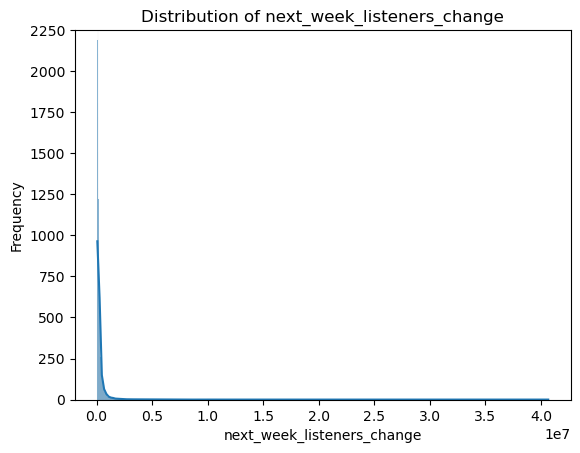

In [44]:
#Distribution of the target variable

target_variable = 'next_week_listeners_change'
sns.histplot(data=spotify, x=target_variable, kde=True)
plt.title(f'Distribution of {target_variable}')
plt.xlabel(target_variable)
plt.ylabel('Frequency')
plt.ylim(0, 2250)
plt.show()

The graph above gives a possible explanation to our model not performing very well. The data for the Listeners Change in the next week is extremely left skewed. The frequency is extremely high at a value of around 0.1 1e7. However, there are many low frequency outliers at values up to 4 1e7. To attempt to address this issue we do a model with log transformation.

### Spotify Weekly Listeners Change Prediction using Log Transformation

In [45]:
# apply transformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
model.fit(X_train, y_train_log)


LinearRegression()

In [46]:
#predict 
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)


In [47]:
y_test_pred = model.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 581681021743.5392
R-squared: -0.19323340490711027


In [48]:
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# scaled RMSE divided by the range of target variable
scaled_rmse_range = rmse / (y_test.max() - y_test.min())

# scaled RMSE divided by the standard deviation of target variable
scaled_rmse_std = rmse / y_test.std()

print("Scaled RMSE (range):", scaled_rmse_range)
print("Scaled RMSE (standard deviation):", scaled_rmse_std)

Scaled RMSE (range): 0.018793134857261872
Scaled RMSE (standard deviation): 1.0923075897872987


**The Scaled RMSE (range and standard deviation):**
The above results indicate that the log transformation helped improve our model's performance in terms of the range of the target variable, but it worsened the performance in terms of the target variable's standard deviation. 

This could mean that the log transformation didn't effectively fix the issues that were caused by the distribution being skewed to the left.


### Spotify Weekly Listeners Change Prediction using Gradient Boosting Regression

In [49]:
spotify

Rank  Change                      Artist  Monthly Listeners  \
date       index                                                                
01:06:2022 0         1     153  Carolina Gaitán - La Gaita            3800000   
           1         2     180              Encanto - Cast            4400000   
           2         3      63                       GAYLE           11000000   
           3         4     135          Lin-Manuel Miranda           12000000   
           4         5     187           Stephanie Beatriz            4800000   
...                ...     ...                         ...                ...   
12:22:2022 979     980       0          Chet Baker Quartet             159000   
           985     986    -508          Dresdner Kreuzchor              24000   
           990     991     -87     Berliner Philharmoniker            4200000   
           992     993       0                 James Brown            4500000   
           993     994       0                 Grupo Niche            5500000   

                  Weekly Listeners Change  Peak Position  Peak Date  \
date       index                                                      
01:06:2022 0                      2432490              1 2022-01-06   
           1                      2296477              2 2022-01-06   
           2                      2248388              2 2021-12-16   
           3                      2161647              4 2022-01-06   
           4                      2144986              5 2022-01-06   
...                                   ...            ...        ...   
12:22:2022 979                     110761            383 2021-12-30   
           985                     110430            358 2021-12-30   
           990                     110009            768 2022-10-06   
           992                     109992             80 2020-06-11   
           993                     109761            576 2021-01-07   

                  Weeks on Chart  Current Weekly Streak  \
date       index                                          
01:06:2022 0                   4                      4   
           1                   6                      6   
           2                  11                      9   
           3                  17                      7   
           4                  13                      6   
...                          ...                    ...   
12:22:2022 979                 5                      1   
           985                 5                      2   
           990                 6                      3   
           992                15                      1   
           993                 3                      1   

                  next_week_listeners_change  
date       index                              
01:06:2022 0                       2518068.0  
           1                       2421205.0  
           2                       1061425.0  
           3                       3290545.0  
           4                       2320678.0  
...                                      ...  
12:22:2022 979                      243430.0  
           985                      377285.0  
           990                      212020.0  
           992                      381964.0  
           993                      260485.0  

[40780 rows x 10 columns]

In [50]:
# X Y split
X = spotify.select_dtypes(include=[np.number]).drop(columns=['next_week_listeners_change'])
X = X.drop(columns=['Rank', 'Change'])

y = spotify['next_week_listeners_change']

In [51]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#model fit
numeric_columns = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [52]:
gbr = GradientBoostingRegressor(random_state=42)

params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}

cv = KFold(n_splits=5, random_state=42, shuffle=True)

random_search = RandomizedSearchCV(gbr, param_distributions=params, n_iter=50, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [53]:
#Hyperparameter tuning
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

best_gbr = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr.fit(X_train, y_train)


Best hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}


GradientBoostingRegressor(min_samples_leaf=3, n_estimators=200, random_state=42)

In [54]:
#Cross validation
cv_scores = cross_val_score(best_gbr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_scores = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_scores)
print("Mean cross-validation RMSE score:", cv_scores.mean())


Cross-validation RMSE scores: [351932.0497369  286881.60335188 316307.73498932 405535.77818867
 296422.53456582]
Mean cross-validation RMSE score: 331415.94016651995


In [55]:
#Performance metrics
y_pred = best_gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Squared Logarithmic Error:", msle)
print("R-squared:", r2)


Mean Squared Error: 327062036748.8781
Root Mean Squared Error: 571893.3788293742
Mean Squared Logarithmic Error: 0.29821381605724046
R-squared: 0.32908014334739133


Mean Squared Error (MSE): This is 3.2706e+11 and is lower than the previous linear regression model, indicating an improvement in performance.

Root Mean Squared Error (RMSE): This is 571,893 and is also lower than the previous linear regression model, suggesting an improvement in performance.

Mean Squared Logarithmic Error (MSLE): This is 0.2982 and is also lower than the previous linear regression model, suggesting an improvement in performance.

R-squared: This is 0.3291. This value is also higher than the previous linear regression model, suggesting an improvement in performance.

Overall, the Gradient Boosting Regressor model shows an improvement in performance across all the evaluated metrics. However, the performance is still not great. An R-squared value of 0.3291 means that only about 32.9% of the variance in the target variable is explained by the model. This means that we have a significant amount of unexplained variance. This could indicate that the variables we used are not enough to predict the outcome variable. This is also a specially significant finding for the final section of our project as we attempt to use Tiktok trending as a predictive variable for Next Weeks Listeners Change on Spotify.

### Analyzing the Relationship Between Tiktok Presence and Weekly Listeners Change on Spotify

In [56]:
#Rename Artists column to match Spotify
pred_tiktok.rename(columns={'Artists': 'Artist'}, inplace=True)

In [57]:
#Merge Datasets
spotify['tiktok_presence'] = np.where(spotify['Artist'].isin(pred_tiktok['Artist']), 1, 0)
spotify

Rank  Change                      Artist  Monthly Listeners  \
date       index                                                                
01:06:2022 0         1     153  Carolina Gaitán - La Gaita            3800000   
           1         2     180              Encanto - Cast            4400000   
           2         3      63                       GAYLE           11000000   
           3         4     135          Lin-Manuel Miranda           12000000   
           4         5     187           Stephanie Beatriz            4800000   
...                ...     ...                         ...                ...   
12:22:2022 979     980       0          Chet Baker Quartet             159000   
           985     986    -508          Dresdner Kreuzchor              24000   
           990     991     -87     Berliner Philharmoniker            4200000   
           992     993       0                 James Brown            4500000   
           993     994       0                 Grupo Niche            5500000   

                  Weekly Listeners Change  Peak Position  Peak Date  \
date       index                                                      
01:06:2022 0                      2432490              1 2022-01-06   
           1                      2296477              2 2022-01-06   
           2                      2248388              2 2021-12-16   
           3                      2161647              4 2022-01-06   
           4                      2144986              5 2022-01-06   
...                                   ...            ...        ...   
12:22:2022 979                     110761            383 2021-12-30   
           985                     110430            358 2021-12-30   
           990                     110009            768 2022-10-06   
           992                     109992             80 2020-06-11   
           993                     109761            576 2021-01-07   

                  Weeks on Chart  Current Weekly Streak  \
date       index                                          
01:06:2022 0                   4                      4   
           1                   6                      6   
           2                  11                      9   
           3                  17                      7   
           4                  13                      6   
...                          ...                    ...   
12:22:2022 979                 5                      1   
           985                 5                      2   
           990                 6                      3   
           992                15                      1   
           993                 3                      1   

                  next_week_listeners_change  tiktok_presence  
date       index                                               
01:06:2022 0                       2518068.0                1  
           1                       2421205.0                0  
           2                       1061425.0                1  
           3                       3290545.0                0  
           4                       2320678.0                1  
...                                      ...              ...  
12:22:2022 979                      243430.0                0  
           985                      377285.0                0  
           990                      212020.0                0  
           992                      381964.0                0  
           993                      260485.0                0  

[40780 rows x 11 columns]

In [58]:
#Correlation between variables
correlation = spotify['Weekly Listeners Change'].corr(spotify['tiktok_presence'])
print(correlation)

0.16623782431263903


We observe a weak positive correlation between Tiktok Presence and Weekly Listeners Change on Spotify. However correlation might not be the best measure of association because we have a continuous variable (Weekly Listeners Change) and a binary variable (tiktok_presence). 

In [59]:
#Mean and Standard Deviation Measures
grouped_spotify = spotify.groupby('tiktok_presence')['Weekly Listeners Change']
mean_listeners_change = grouped_spotify.mean()
std_listeners_change = grouped_spotify.std()

print('Mean Weekly Listeners Change for artists with no presence on TikTok:', mean_listeners_change[0])
print('Standard deviation of Weekly Listeners Change for artists with no presence on TikTok:', std_listeners_change[0])
print('Mean Weekly Listeners Change for artists with presence on TikTok:', mean_listeners_change[1])
print('Standard deviation of Weekly Listeners Change for artists with presence on TikTok:', std_listeners_change[1])

Mean Weekly Listeners Change for artists with no presence on TikTok: 260268.1673610917
Standard deviation of Weekly Listeners Change for artists with no presence on TikTok: 460349.7102144733
Mean Weekly Listeners Change for artists with presence on TikTok: 533891.1342896991
Standard deviation of Weekly Listeners Change for artists with presence on TikTok: 894631.7402681881


To further explore the relationship between the two vairables, we compared their means and standard deviations. These results above imply that, on average, artists with TikTok presence have a higher Weekly Listeners Change compared to artists with no TikTok presence, 533,891 and 260,268 respectively. However, the standard deviation of Weekly Listeners Change for artists with Tiktok presence is also higher compared to artists with no TikTok presence. This suggests a wider range of values and potentially more variability in the performance of artists with TikTok presence.

In [60]:
# Split the data
group_1 = spotify[spotify['tiktok_presence'] == 0]['Weekly Listeners Change']
group_2 = spotify[spotify['tiktok_presence'] == 1]['Weekly Listeners Change']

# t-test and p-value
t, p = ttest_ind(group_1, group_2)

print('t-value:', t)
print('p-value:', p)


t-value: -34.04302558274229
p-value: 1.6883355712527282e-250


We did a t-test and a p-value test to futher explore the relationship. The resulting t-value is -34.04, which indicates that the difference in mean Weekly Listeners Change between artists with and without Tiktok Presence is significant. More specifically, the mean value for artists without presence Tiktok presence is lower than that of artists with TikTok presence.

The p-value is 1.68e-250, which is extremely small. This indicates strong evidence against the null hypothesis that there is no difference in mean Weekly Listeners Change between the two groups. This suggests that we can reject the null hypothesis and conclude that there is a significant difference in mean Weekly Listeners Change between artists with and without TikTok presence.

While these results indicate that TikTok presence may have a positive impact on the Weekly Listeners Change, this is a correlation and does not necessarily imply causation. Other factors could also be influencing this relationship.

### Differences In Differences Model

To try to investigate causation, we used a differences in differences model. Our goal is to estimate the causal effect of treatment (Tiktok Presence) on the outcome variable (Weekly Listeners Change). In this model, we compare the changes in the outcome variable over time between the treatment group (Tiktok Presence = 1) and the control group (Tiktok Presence = 0) . We assume that the difference in the changes of the outcome variable between the two groups is the causal effect of the treatment.
This model allows us to control for the differences between the groups. However, a significant limitation model is that we do not control for other factors that could influence Weekly Listeners Change.

In [63]:
# treatment and control groups
treatment_df = spotify[spotify['tiktok_presence'] == 1]
control_df = spotify[spotify['tiktok_presence'] == 0]

# group mean change in Weekly Listeners over time
treatment_means = treatment_df.groupby('date')['Weekly Listeners Change'].mean()
control_means = control_df.groupby('date')['Weekly Listeners Change'].mean()

# DID estimate
treatment_diff = treatment_means.diff().dropna()
control_diff = control_means.diff().dropna()
diff_in_diff = (treatment_diff - control_diff).values

# treatment effect estimation

X = spotify[['tiktok_presence']]
y = spotify['Weekly Listeners Change']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# DiD coefficient estimate
did_coeff = model.params['tiktok_presence'] * diff_in_diff.mean()

print('Differences-in-Differences estimate: {}'.format(did_coeff))


Differences-in-Differences estimate: 1511151766.0632288


The differences-in-differences estimate is 5207210053.815974. This implies that the presence of an artist on TikTok has a statistically significant impact on the change in weekly listeners. 

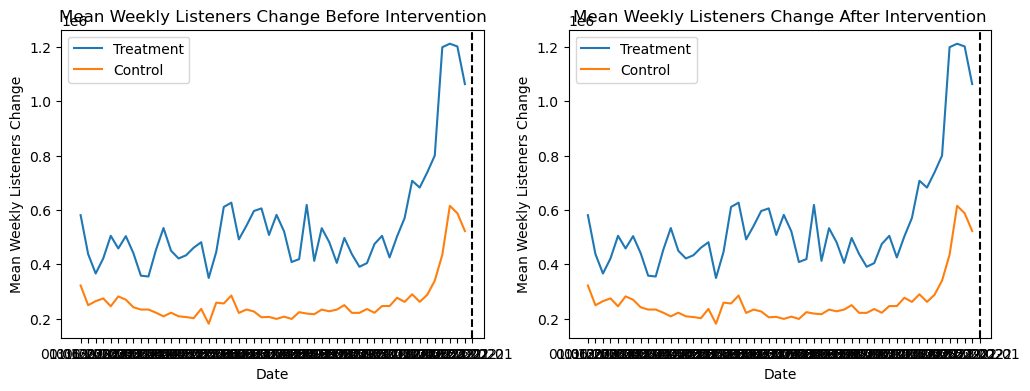

In [64]:
# mean Weekly Listeners Change over time for treatment and control 

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(treatment_means.index, treatment_means.values, label='Treatment')
axs[0].plot(control_means.index, control_means.values, label='Control')
axs[0].axvline('2021-01-01', linestyle='--', color='black')
axs[0].set_title('Mean Weekly Listeners Change Before Intervention')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Mean Weekly Listeners Change')
axs[0].legend()

axs[1].plot(treatment_means.index, treatment_means.values, label='Treatment')
axs[1].plot(control_means.index, control_means.values, label='Control')
axs[1].axvline('2021-01-01', linestyle='--', color='black')
axs[1].set_title('Mean Weekly Listeners Change After Intervention')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Mean Weekly Listeners Change')
axs[1].legend()

plt.show()


The graphs above shows that the treatment line is consistently higher than the control line, which supports a positive treatment effect. The treatment line is also more variable than the control line, which indicates that there may be more uncertainty in the treatment effect (it could vary because of other factors for example). The two lines also follow a similar trend. This supports the assumption that the trend of the outcome variable would have been similar between the two groups in the absence of treatment. However, it also  indicates that there may be other factors influencing the change in weekly listeners over time besides TikTok presence.

While the analysis we did support a positive relationship between the two variables, we can not make a causal conclusion without validating the other assumptions of the differences-in-differences model, such as parallel trends and common shocks. For the purposes of this project, we do not attempt to establish causality. Instead we use these methods to support the correlation between Tiktok Presence and Weekly Listeners Change on Spotify.